In [1]:
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel
from casadi import SX, vertcat, tan, cos, sin, mtimes
import numpy as np
from systems import *
from controllers import *
from control.matlab import *

class DynamicBycicle2(System):
    def __init__(self, m = 1580, J = 3650, a = 1.44, wheelbase = 2.65, Cf = 75*1e3, Cr = 75*1e3, use_slipping = True):
        self.state = [SX.sym('d'), SX.sym('psi'), SX.sym('vy'), SX.sym('wz')]
        self.input_signals = [SX.sym('u')]
        self.params = [SX.sym('vx'), SX.sym('c'), SX.sym('wheelbase')]
        self.a = a
        self.Cf = Cf
        self.Cr = Cr
        self.wheelbase = wheelbase
        self.m = m
        self.J = J
        self.use_slipping = use_slipping

    def get_system(self):
        d, psi, vy, wz = self.state
        vx, c, wheelbase = self.params
        delta = self.input_signals[0]

        alfa_f = np.arctan2(vy + wheelbase * wz, vx) - delta
        alfa_r =  np.arctan2(vy, vx)
        alfa_f = (vy + wheelbase * wz)/ vx - delta
        alfa_r =  vy/ vx

        Ff = -alfa_f * self.Cf 
        Fr = -alfa_r * self.Cr 
        b = wheelbase - self.a
        wz_dot = (self.a * Ff - b * Fr)/self.J
        vy_dot = (Ff + Fr)/self.m - vx * wz + wz_dot*b

        if(self.use_slipping):
            d_dot = vx * np.sin(psi) + vy * np.cos(psi) 
            psi_dot = wz  - c * (vx * np.cos(psi) - vy * np.sin(psi)) / (1 - c * d)
        else:
            d_dot = vx * np.sin(psi) 
            psi_dot = wz  - c * (vx * np.cos(psi)) / (1 - c * d) 
            
        if (self.use_slipping):
            d_dot = vx *psi +  vy 
            psi_dot = wz -  c * (vx - vy * psi)*(1 + c * d)
        else:
            d_dot = vx * psi
            psi_dot = wz -   c * (vx) *(1 + c * d) 

        state_dot = vertcat(d_dot, psi_dot, vy_dot, wz_dot)
        return vertcat(*self.state), vertcat(*self.input_signals), vertcat(*self.params), state_dot



In [2]:

class TrajectoryTimeProfile:
    def __init__(self, f_vel, f_curv):
        self.vel_profile = f_vel
        self.curv_profile = f_curv

def adaptation(what, params, un, table):
    f1 = un
    f2 = 0.1*0

    theta = np.array([f1, f2])
    vec_size = len(theta)
    ua = what[:vec_size]@theta
    ids = np.arange(0, vec_size)
    ids_features = np.arange(0, vec_size)
    return ua, ids, ids_features,  theta

class Mrac:
    def __init__(self, 
                 referene_model: AcadosModel, 
                 controller: Controller,
                 trajectory: TrajectoryTimeProfile,
                 adaptation_f,
                 gamma, sigma, dt):
        self.referene_model = referene_model
        self.controller = controller
        self.integrator = Integrator(referene_model)
        self.trajectory = trajectory
        self.gamma = gamma
        self.adaptation_f = adaptation_f
        self.x_len = referene_model.x.size()[0]
        self.R = np.ones(self.x_len)
        self.dt = dt
        self.R[0]  = 1
        #Simulation parameters
        ADAPT_VECTOR_SIZE = 5
        self.what = np.zeros(ADAPT_VECTOR_SIZE)
        self.whatf = np.zeros(ADAPT_VECTOR_SIZE)
        self.L = 0
        self.alfa_sm = 0.0
        self.gam = gamma
        self.sig = sigma

    def reset(self, x0):
        self.ref_state = x0[:self.x_len]
   
    def step(self, state, un, t):
        d = self.ref_state[0]
        curr_curv = self.trajectory.curv_profile(t)
        curr_vel = self.trajectory.vel_profile(t)
        params = np.hstack((curr_vel, curr_curv))

        self.controller.set_params(params)
        #params = np.hstack((params, self.controller.params))

        #print("ref state", self.ref_state)
        u_ref = self.controller.action(np.hstack((d, self.ref_state[1:])))
        self.ref_state = self.integrator.step(self.ref_state, u_ref, params, self.dt)
        A, B, D = self.integrator.get_lin_system_dynamics(self.ref_state, u_ref, params)
        K_fb = self.controller.get_fb_gain()
        A_close = get_close_loop_matrix(A, B, K_fb)
        eigs_close_loop_real = np.real(eig(A_close)[0])

        P = linalg.solve_continuous_lyapunov(A_close.T, -np.diag(self.R))

        #Y = integrator.get_jac_param(ref_state, u_ref, params).T[0]
        # BTP = B.T@P
        err = state - self.ref_state
        # err_mrac = BTP@err
        #print("err_mrac: ", err_mrac, BTP)
        # ua, ids, ids_f, thetas = self.adaptation_f(self.what, params, un, False)
        # assert len(ids) == len(thetas)
        # for j, id in enumerate(ids):   
        #     f_id = ids_f[j]
        #     self.what[id] += (self.gam[f_id] * (thetas[j] * err_mrac)- self.sig[id] * (self.what[id] - self.whatf[id])) * dt
        #     self.whatf[id] += (self.alfa_sm * (self.what[id] - self.whatf[id])) * dt


        #self.what[0] +=  Y@P@err*dt
        ua =  self.what[0:1]@(B.T@Y/(B.T@B)[0])

        # print("err_mrac: ", err_mrac, un)
        print("err: ",err)
    
        # ua += self.what[4]*un
        if(not np.all(eigs_close_loop_real < 0.0)):
            raise BaseException("positive eigenvals")
        
        self.L = self.ref_state@P@self.ref_state

        return self.ref_state, ua

#ref_model = make_acados_model(KinematicBycicle(), "kinemetic")
#ref_model = make_acados_model(KinematicBycicleLin(), "kinemetic")

# ref_model = make_acados_model(KinematicBycicleActuator(), "kinemetic")

ref_model = make_acados_model(DynamicBycicle2(m = 1580, J = 3650, a = 1.44, wheelbase = 2.65, Cf = 100 * 1e3, Cr = 100 * 1e3), "car_model_dynamic")

controller = PID_Controller(K_fb=np.array([0.1, 0.8, 0.0, 0.0]), wheelbase = 1.0*2.5)

integrator = Integrator(ref_model)
ref_state = np.array([0.05, 0.3, 0.01, 0.08])
#ref_state = np.array([0.1, 0.03])*0
params = np.array([10, 0.02, 2.5])

controller.set_params(params)

u_ref = controller.action(ref_state)
A, B, D = integrator.get_lin_system_dynamics(ref_state, u_ref, params)

K_fb = controller.get_fb_gain()
A_close = get_close_loop_matrix(A, B, K_fb)


R = np.ones(len(ref_state))
P = linalg.solve_continuous_lyapunov(A_close.T, -np.diag(R))

Y = integrator.get_jac_param(ref_state, u_ref, params).T[0]
eigs_close_loop_real = np.real(eig(A_close)[0])
BTP = -P@B
err_mrac = B.T@P@ref_state
# mrac = Mrac(ref_model, controller, 0.01, 0)
# mrac.reset(np.array([0.1, 0.01]))
# mrac.step(np.array([10, 0.01, 2.65]))
#         BTP = -B@P

In [3]:
what = np.zeros(3)

what[0:1]@(B.T@Y/(B.T@B)[0])


np.float64(0.0)

In [4]:
B.T@Y/(B.T@B)

array([[-0.07921098]])

In [5]:
a = np.array([1,2,3])
b = np.hstack((a,a))
b = np.hstack((a,a))

In [6]:
class ControllerLinear(Controller):
    def __init__(self, model: AcadosModel, K_fb: np.array, params: np.array = np.array([]), label  ="ref"):
        self.K_fb = K_fb
        self.integrator = Integrator(model)
        self.params = params
        self.label = label

    def calc_steady_state(self, x0):
        params = np.array([self.vx, self.curv])
        #params = np.hstack((params1, self.params))
        # print("------")
        # print(x0, params)
        if(np.abs(self.curv) < 1e-4):
            return np.zeros_like(x0)
        u_p = np.array([0])
        A, B, D = self.integrator.get_lin_system_dynamics(x0, u_p, params)
        print(self.label, self.K_fb)
        A_close = get_close_loop_matrix(A, B, self.K_fb)
        eigs_close_loop_real = np.real(eig(A_close)[0])
        if(not np.all(eigs_close_loop_real < 0.0)):
            print("positive eigenvals:", params, x0)
            raise BaseException("positive eigenvals")

        #A_close = A
        A1 = A_close[:, 0:1]  # coefficients for d
        A2 = A_close[:, 1:2]  # coefficients for psi
        A3 = A_close[:, 2:3]  # coefficients for vy
        A4 = A_close[:, 3:4]  # coefficients for wz

        # Construct matrix M and vector N
        M = np.hstack([A2, A3, A4, B])  # 4x4 matrix

        N = (D) * self.curv # 4x1 vector
        # print("\n=== SYSTEM ANALYSIS ===")
        # print(f"Matrix M shape: {M.shape}")
        # print(f"Rank of M: {np.linalg.matrix_rank(M)}")
        # print(f"Rank of [M | N]: {np.linalg.matrix_rank(np.hstack([M, N]))}")
            
        z = -np.linalg.inv(M) @ N 
        psi, vy, wz, u = z
        x_ss = np.hstack([0, psi, vy, wz])
        #print("res: ",A_close@x_ss[:, np.newaxis] + B*u +  D[:, 1:]*self.curv)
        #print((B*u).shape, (A_close@x_ss[:, np.newaxis]).shape, D[:, 1:].shape)
        return np.hstack([x_ss, u])
    
    def action(self, x0):
        x_ss = self.calc_steady_state(x0)
        u_ff = x_ss[-1]
        diff = x0[:4]# - x_ss[:4]
        u_fb = -self.K_fb[:]@(diff)
        u_opt = u_fb  + u_ff
        # print(self.label,"u", u_ff, u_fb, u_ff )
        # print(self.label, "x_ss", x_ss)
        # print(self.label, "diff",  diff)
        return np.array([u_opt])
    
    def set_params(self, params):
        vx, c = params[:2]
        self.curv = c
        self.vx = vx

    def get_fb_gain(self):
        return self.K_fb



In [7]:
# model = make_acados_model(DynamicBycicle(m = 1580, J = 3650, a = 1.44, wheelbase = 2.65, Cf = 100 * 1e3, Cr = 100 * 1e3), "car_model_dynamic")
# controller = ControllerLinear(model, K_fb = np.array([0.1, 0.2, 0.0, 0]))
# params = np.array([10, 0.01])
# controller.set_params(params)
# state = np.array([0.0, 0.0, 0.0, 0.0])
# u_ref = controller.action(state)
# u_ref


# A_close = get_close_loop_matrix(A, B, controller.get_fb_gain())
# eigs_close_loop_real = np.real(eig(A_close)[0])

# print("EIG2" ,eigs_close_loop_real)

# mrac = Mrac(model, controller, adaptation, gamma = 25*np.array([0.1, 0.1, 0.1]), sigma = 0*np.array([0.1, 0.1, 0.1]))
# mrac.reset(state)
# mrac.step(state, u_ref[0],params, 0.01)

In [8]:
# real_model = make_acados_model(DynamicBycicle(m = 1580, J = 3650, a = 1.44, wheelbase = 2.65, Cf = 100 * 1e3, Cr = 100 * 1e3), "car_model_dynamic")

# integrator = Integrator(real_model)
# A, B, D = integrator.get_lin_system_dynamics(np.array([0, 0.0, 0, 0]), np.array([0]), np.array([10, 0.01]))
# real_model2 = make_acados_model(LinearSystem(A, B, D), "lin")


# integrator2 = Integrator(real_model2)
# A2, B2, D2 = integrator2.get_lin_system_dynamics(np.array([0.1, 0.1, 0.2, -0.12]), np.array([0]), np.array([10, 0.01]))
# print(A-A2, B - B2)

# controller1 = ControllerLinear(real_model, K_fb = np.array([0.1, 0.8, 0.6, 0]))
# params = np.array([10, 0.01])
# controller1.set_params(params)

# controller2 = ControllerLinear(real_model2, K_fb = np.array([0.1, 0.8, 0.6, 0]))
# params = np.array([10, 0.01])
# controller2.set_params(params)

# state = np.array([0.1, 0.1, -0.1, 0.14])

# u1 = controller1.action(state)
# u2 = controller2.action(state)
# print(u1 -u2)

# # mrac = Mrac(real_model, controller1, adaptation, gamma = 25*np.array([0.1, 0.1, 0.1]), sigma = 0*np.array([0.1, 0.1, 0.1]))
# # mrac.step(state, u1, params, 0.01)

In [9]:
import numpy as np

from scipy import interpolate


def simulate_car_control(real_model:AcadosModel, 
                         controller: Controller, 
                         params_real: np.array,
                         mrac: Mrac,
                         trajectory: TrajectoryTimeProfile,
                         dt, t_list,
                         use_distortion = False,
                         use_adapation = False):

    integrator = Integrator(real_model)

    # Initial state
    STATE_LENGTH = len(real_model.x.elements())
    x0 = np.zeros(STATE_LENGTH)
    x0[0] = 0.1
    x0[1] = 0.02
    # Storage
    N_sim = len(t_list)
    states = np.zeros((N_sim + 1, 10))
    controls = np.zeros((N_sim, 1))
    controls_actual = np.zeros((N_sim, 1))
    debug_w =  np.zeros((N_sim, 5))
    states[0, :STATE_LENGTH] = x0
    x_current = x0
    x0_solver = np.zeros(4)
    x0_solver[0] = x_current[0] / trajectory.vel_profile(t_list[0])
    x0_solver[1] = x_current[1]
    ref_model_state = x_current
    mrac.reset(ref_model_state)
    control_gain = 1.0 * 0.9 
    control_bias = 0.0005*0
    
    def disturbance(u):
        return (u + control_bias) * control_gain
    
    for i, t in enumerate(t_list[:-1]):
        curr_curv = trajectory.curv_profile(t)
        curr_vel = trajectory.vel_profile(t)
        params = np.hstack((curr_vel, curr_curv))
        #params = np.hstack((params1, params_real))
        controller.set_params(params)

        u = u_n = controller.action(x0_solver)[0]
        if(use_distortion):
            u = disturbance(u_n)
        ref_model_state, ua = mrac.step(x_current, u_n, t)
        if(use_adapation):
            u -= ua
            print("ua", ua)
        x_current = integrator.step_jax(x_current, np.array([u]), params, dt)
        print("t: ", t, "                  ", x_current)
        
        d, psi = x_current[:2]
        #x0_solver = np.hstack((d/curr_vel, x_current[1:]))  
        x0_solver = np.hstack((d, x_current[1:]))  

        controls[i] = controller.get_data()
        controls_actual[i] = u
        states[i+1, :STATE_LENGTH] =  x_current
        states[i+1, STATE_LENGTH: STATE_LENGTH + mrac.x_len] =  ref_model_state
        debug_w[i] = np.hstack((mrac.what))
    return t_list, states, controls, controls_actual, debug_w


def plot_results(times, states, controls, controls_actual, debug):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
    STATE_LENGTH = len(real_model.x.elements())
    ax1.plot(times, states[:-1, 0], 'b-', linewidth=2, label = r'$d$')
    ax1.plot(times, states[:-1, STATE_LENGTH], 'r-', linewidth=2, label = r'$d_{ref}$')
    ax1.set_ylabel('Lateral deviation [m]')
    ax1.grid(True)
    ax1.legend()
    ax1.axhline(y=0, color='r', linestyle='--')
    
    ax2.plot(times, states[:-1, 1], 'b-', linewidth=2, label = r'$\psi$')
    ax2.plot(times, states[:-1, 2], 'k-', linewidth=2, label = r'$\psi$')
    ax2.plot(times, states[:-1, 3], 'g|-', linewidth=2, label = r'$\psi$')
    ax2.plot(times, states[:-1, 1 + STATE_LENGTH], 'r-', linewidth=2, label = r'$\psi_{ref}$')
    ax2.set_ylabel('Heading angle [rad]')
    ax2.grid(True)
    ax1.legend()
    ax2.axhline(y=0, color='r', linestyle='--')
    
    #ax3.plot(times, states[:-1, 2], 'g-', linewidth=2)
    ax3.plot(times, controls_actual, 'k', linewidth=2)
    ax3.set_ylabel('Steering angle[rad]')
    ax3.grid(True)
    ax3.axhline(y=0, color='r', linestyle='--')

    ax4.plot(times[:], debug[:, :], linewidth=2)
    ax4.grid(True)
    # ax4.set_ylabel('qq]')
    # ax4.set_xlabel('Time [s]')
    # ax4.grid(True)
    # ax4.axhline(y=0, color='k', linestyle='--')
    plt.tight_layout()
    plt.show()



In [10]:
#real_model = make_acados_model(KinematicBycicleActuator(), "car_model")

#real_model = make_acados_model(KinematicBycicle(), "kinematic")


#controller = PID_Controller(K_fb=np.array([0.02, 0.4, 0.0, 0.0]), wheelbase = 1.0*2.5, yaw_rate_conpensation=0)


ref_model =  make_acados_model(DynamicBycicle(m = 1980, J = 4650, a = 1.44, wheelbase = 2.65, Cf = 100 * 1e3, Cr = 100 * 1e3), "car_model_dynamic2")
ref_controller = ControllerLinear(ref_model, K_fb =np.array([0.05, 0.8, 0.0, 0.0]), params = np.array([2.65]), label = "ref")


real_model = make_acados_model(DynamicBycicle(m = 1980, J = 4650, a = 1.44, wheelbase = 2.65, Cf = 100 * 1e3, Cr = 120 * 1e3), "car_model_dynamic")
controller = ControllerLinear(real_model, K_fb =np.array([0.05, 0.8, 0.0, 0.0]), params = np.array([2.65]), label = "real")

controller = ref_controller

# ref_model = make_acados_model(KinematicBycicle(), "kinematic")
#ref_controller = PID_Controller(K_fb=np.array([0.1, 0.8, 0, 0]), wheelbase = 1.0*3.2)   

# real_model = make_acados_model(KinematicBycicle(), "kinematic")
# controller = PID_Controller(K_fb=np.array([0.2, 0.2, 0, 0]), wheelbase = 1.0*2.5)   


dt = 0.01
c_max = 0.01*0
c_bias = 0.015
d_curv_max = 10
N_repeat = 1
T_max = 20
t_list = np.arange(0, T_max, dt)
curv_reference = c_max * (np.tanh(d_curv_max * (t_list - 10)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 20)) + 1) / 2 + \
            - (c_max * (np.tanh(d_curv_max * (t_list - 30)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 40)) + 1) / 2) + c_bias

t_list = np.arange(0, T_max * N_repeat, dt)
curv_reference = np.hstack(N_repeat*[curv_reference])

vel_reference = 15*np.ones_like(t_list)
f_vel = interpolate.interp1d(t_list, vel_reference, kind = 'linear')
f_curv = interpolate.interp1d(t_list, curv_reference, kind = 'linear')

trajectory = TrajectoryTimeProfile(f_vel, f_curv)
mrac = Mrac(ref_model, ref_controller, trajectory, adaptation, gamma = 25*np.array([0.1, 0.1, 0.1]), sigma = 0*np.array([0.1, 0.1, 0.1]), dt = dt)


times, states, controls, controls_actual, debug = simulate_car_control(real_model, controller, np.array([2.55]), mrac, trajectory, dt, t_list, use_distortion = 0, use_adapation = 0)

print("Simulation completed!")
print(f"Final lateral deviation: {states[-1, 0]:.4f} m")
print(f"Final heading angle: {states[-1, 1]:.4f} rad")


ref [0.05 0.8  0.   0.  ]
ref [0.05 0.8  0.   0.  ]
err:  [-0.00300922  0.00218935 -0.03395285 -0.01267124]
t:  0.0                    [0.10302803 0.01781768 0.03750782 0.01408428]
ref [0.05 0.8  0.   0.  ]
ref [0.05 0.8  0.   0.  ]
err:  [-0.00298724  0.0020712  -0.02572335 -0.01096265]
t:  0.01                    [0.10606775 0.01576802 0.06597944 0.02654923]
ref [0.05 0.8  0.   0.  ]
ref [0.05 0.8  0.   0.  ]
err:  [-0.00292385  0.0019635  -0.02218106 -0.0105785 ]
t:  0.02                    [0.10907165 0.01384187 0.09004334 0.0388018 ]
ref [0.05 0.8  0.   0.  ]
ref [0.05 0.8  0.   0.  ]
err:  [-0.00284273  0.00186008 -0.01900334 -0.01011244]
t:  0.03                    [0.11201555 0.012037   0.10999766 0.05082383]
ref [0.05 0.8  0.   0.  ]
ref [0.05 0.8  0.   0.  ]
err:  [-0.00274673  0.00176167 -0.01617944 -0.00958329]
t:  0.04                    [0.11487781 0.01035102 0.1261268  0.062599  ]
ref [0.05 0.8  0.   0.  ]
ref [0.05 0.8  0.   0.  ]
err:  [-0.00263855  0.00166881 -0.01369

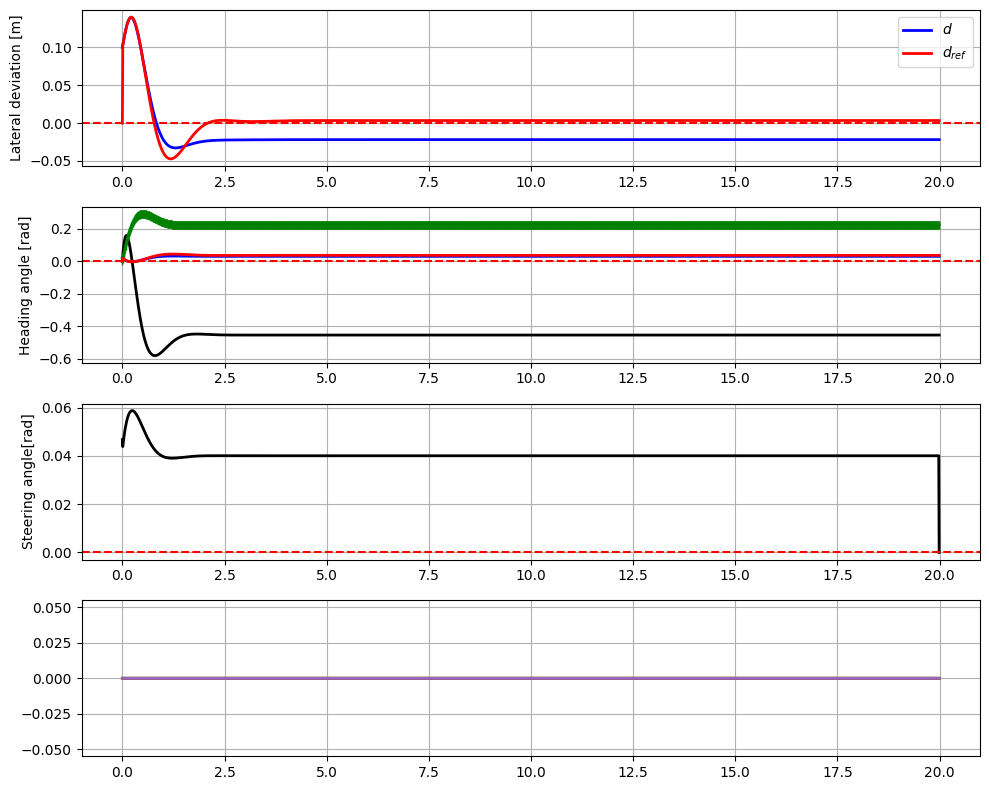

In [11]:
plot_results(times, states, controls, controls_actual, debug)

In [10]:
%matplotlib ipympl
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import interpolate
from numpy.linalg import eig
from scipy import linalg
import math
import copy
import matplotlib.pyplot as plt
from numpy.linalg import eig
from scipy import linalg
from systems import *
N1 = 6
N2 = 10
TABLE_SIZE = int(N1*N2)
N_Features = 2
ADAPT_VECTOR_SIZE = int(N_Features*TABLE_SIZE)
ADAPT_VECTOR_SIZE = 5

plt.close() 
plt.ioff()

# k_p = 420.9, k_v = 49.61, a = 18.601, b = 2304.0, d = 164.8, tau = 0.0017, v_ch = 26.2628

### INITIAL CONDITION
STATE_LENGTH = 4
STATE_LENGTH_REF = 6
T_max = 100#14.5
dt = 0.02
N_repeat = 1
what0 = np.array([0.0]*ADAPT_VECTOR_SIZE)
what0[0] = 0.0
what0[1] = -0.0
what0[2] = 0.0
whatf0 = np.copy(what0)
d0 = 0.12
phi0 = 1*np.pi/180
w0 = 0.0
wdot0 = 0.0
velocity0 = 20.0

### INPUT SIGNALS

# curv_reference = c_max * (np.tanh(1 * (t_list - 10)) + 1) / 2 - c_max * (np.tanh(1 * (t_list - 30)) + 1) / 2
t_list = np.arange(0, T_max, dt)
c_max = 0.004 
c_bias = 0.004*0
d_curv_max = 5/5

curv_reference = c_max * (np.tanh(d_curv_max * (t_list - 10)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 30)) + 1) / 2 + \
              - (c_max * (np.tanh(d_curv_max * (t_list - 50)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 80)) + 1) / 2) + c_bias
# curv_reference = c_max* (tan(t_list - 10, d_curv_max) -  tan(t_list - 30, d_curv_max) + \
#                          tan(t_list - 50, d_curv_max) -  tan(t_list - 80, d_curv_max))

t_list = np.arange(0, T_max * N_repeat, dt)
curv_reference = np.hstack(N_repeat*[curv_reference])

f_curv = interpolate.interp1d(t_list, curv_reference, kind ='cubic')
f_d_curv = interpolate.interp1d(t_list[1:], np.diff(curv_reference)/dt, kind ='cubic')

### MODEL PARAMS
Noise_w = 0.0  ### INITIAL CONDITION
wheelbase = 2.5
Delay = 0.1
N_delay_curcle = int(Delay/dt)

### CONTROL PARAMS
LYAMBDA = 1.0 * 0.9 
control_bias = 0.0005
use_distortion = 1
def disturbance(u):
    return (u + control_bias)*LYAMBDA

theta_true = np.array([(1 - LYAMBDA)/LYAMBDA, -control_bias/0.01, 0, 0, 0])
gam = np.array([0.1, 0.1, 0.1, 0.1, 0.1])*0.5
sig = np.array([1.0] * ADAPT_VECTOR_SIZE) * 1.0*0

K_fb = np.array([0.1, 0.2, 0.3])
K_fb_ref = np.array([0.1, 0.2, 0.3])
alfa_sm = 0.5
k_p = 420.9
k_v = 49.61
a = 5.601
b = 304.0
d = 164.8
tau = 0.0017
v_ch = 26.2628

#car_lateral  = DynamicBicycleFriction(m = 1580, J = 3650, a = 1.44, wheelbase = wheelbase, Cf = np.rad2deg(50*1e3), Cr = np.rad2deg(65*1e3)) # a = 1.44
real_model = make_acados_model(KinematicBycicleActuator(), "car_model_kinematic")
reference_model = make_acados_model(KinematicBycicleActuator(), "car_model_kinematic")
integrator = Integrator(real_model)
controller = SimplePID(wheelbase = wheelbase, K_fb = K_fb)


reference_model = KinematicBicycleActuaror(wheelbase = wheelbase,  kp = 420.9, kv = 49.61, dim = STATE_LENGTH)
controller_reference = SimplePID(wheelbase = wheelbase, K_fb = K_fb)



what = np.zeros(ADAPT_VECTOR_SIZE)
whatf = np.zeros(ADAPT_VECTOR_SIZE)

state0 = np.zeros(STATE_LENGTH)
state0[0] = d0
state0[1] = phi0
# state0[2] = w0

state = np.copy(state0)

state_reference = np.copy(state[:STATE_LENGTH])
A, B = car_lateral.get_lin_system_dyn( 0.0, velocity0)
eigs_close_loop_real = np.real(eig(get_close_loop_matrix(A, B, K_fb))[0])
if(not np.all(eigs_close_loop_real < 0.0)):
    raise BaseException("positive eigenvals")
### MRAC PARAMS
use_adaptation = 1
use_adaptation_part = 1
table_mrac = False

R = -np.array([1, 1, 0.1, 0.001, 0.001, 0.001])

def adaptation(state, what,  c, v, un, table):
    d = state[0]
    psi = state[1]
    f1 = un
    f2 = 0.01
    f3 = 0
    f4 = 0
    f5 = 0

    theta = np.array([f1, f2, f3*0, f4*0, f5*0])
    ua = what@theta
    vec_size = len(theta)
    ids = np.arange(0, vec_size)
    ids_features = np.arange(0, vec_size)
    return ua, ids, ids_features,  theta


### DEBAG SIGNALS
err_rec = np.zeros_like(t_list)
Lyap_full_rec = np.zeros_like(t_list)
Lyap_state_rec = np.zeros_like(t_list)
Lyap_what_rec = np.zeros_like(t_list)
debag_rec =  np.zeros((len(t_list), 1))
u_rec = np.zeros((len(t_list), 11))
state_rec = np.zeros((len(t_list),  max(STATE_LENGTH, 6) + 2*ADAPT_VECTOR_SIZE))
state_reference_rec = np.zeros((len(t_list), max(STATE_LENGTH, 6)))
u_hist = [0]
if(N_delay_curcle > 1) :
    u_hist = u_hist * N_delay_curcle
c_curr_last = f_curv(t_list[0])

def measurements(state):
    return state
    # d = state[0]
    # psi = state[1]
    # w = state[2]
    # wdot = state[3]
    # delta = state[4]
    # deltadot = state[5]
    # #w += np.random.normal(0, Noise_w)
    # w = w #- 0.002
    # psi = psi #+ 0.002
    # state_fb = np.hstack((d, psi, w, wdot, delta, deltadot))
    # return state_fb

for i in range(0, int(len(t_list))):
    if(np.linalg.norm(state) > 100):
        raise BaseException("Solution Disconverge")
    
    t = t_list[i]
    print("t:", t)
    c_curr = f_curv(t)
    
    i_future = i + N_delay_curcle
    if(i + N_delay_curcle > len(t_list)-1):
        i_future = i 

    t_future = t_list[i_future]  #predictor
    sys_state_fb = measurements(state)
    
    d = state[0]
    psi = state[1]
    v = velocity0

    A, B = car_lateral.get_lin_system_dyn(c_curr, v)
    P = get_lapynov_matrix(A, B, R, K_fb)
    Ar = get_close_loop_matrix(A, B, K_fb)

    # assert np.linalg.norm(((Ar.T@P + P@Ar) - np.diag(R))) < 1e-5
    assert np.all(np.linalg.eigvals(P) > 0)
    
    BTP = -B@P
   
    err = state[:STATE_LENGTH] - state_reference[:STATE_LENGTH]


    err_mrac = BTP[:STATE_LENGTH]@(err[:])

    uff, ufb = controller.get_nominal_control(K_fb, sys_state_fb, v, c_curr)

    ua, ids, ids_f, thetas = 0, [], [], []
    if(use_adaptation_part):
        ua, ids, ids_f, thetas = adaptation(sys_state_fb, what, c_curr, v, uff + ufb, False)
        assert len(ids) == len(thetas)

    u = uff + ufb + ua

    uff_ref, ufb_ref = controller_reference.get_nominal_control(K_fb[:2], state_reference, v, c_curr)
    un_ref = uff_ref + ufb_ref


    u_hist.pop(0)
    u_hist.append(u)

    u_delayed = u# u_hist[0]
    if(use_distortion):
        u_delayed = disturbance(u_delayed)

    soln_ref = odeint(lambda state_ , time_: reference_model.sys_dyn(state_, time_, un_ref, v, c_curr), np.copy(state_reference), (t, t + dt), atol = 1e-6, rtol = 1e-6)
    soln    =  odeint(lambda state_ , time_:     car_lateral.sys_dyn(state_, time_, u_delayed, v, c_curr), state[:STATE_LENGTH], (t, t + dt), atol = 1e-6, rtol = 1e-6)
        

    if(use_adaptation):
        for j, id in enumerate(ids):   
            f_id = ids_f[j]
            what[id] += (gam[f_id] * (thetas[j] * err_mrac)- sig[id] * (what[id] - whatf[id])) * dt
            whatf[id] += (alfa_sm * (what[id] - whatf[id])) * dt
            assert len(what) == ADAPT_VECTOR_SIZE
    c_curr_last = c_curr
    state = soln[ -1]
    state_reference = np.copy(soln_ref[ -1])  
    err_rec[i] = -err_mrac
    state_rec[i][:STATE_LENGTH] = state[:STATE_LENGTH]
    state_rec[i][max(STATE_LENGTH, 6):max(STATE_LENGTH, 6) + ADAPT_VECTOR_SIZE] = what
    state_rec[i][2] = car_lateral.get_psi_dot() #state[2] #- v * c_curr*0
    state_reference_rec[i][:STATE_LENGTH] = state_reference[:STATE_LENGTH]
    state_reference_rec[i][2] = reference_model.get_psi_dot()
    u_rec[i] = np.array([uff, ufb, ua, 0, u, 0, 0, 0, 0, 0, 0])

    #CALC LYAPUNOV FUNCTION
    P = P[:STATE_LENGTH, :STATE_LENGTH]
    Lyap_state_rec[i] =  err[:STATE_LENGTH]@P@err[:STATE_LENGTH,np.newaxis]
    Lyap_what_rec[i] =  ((what - theta_true)/gam)@((what - theta_true))*LYAMBDA
    Lyap_full_rec[i] =  Lyap_state_rec[i] +  Lyap_what_rec[i] 

print("Done")

fig, (axes) = plt.subplots(4, 2, figsize = (15, 15)  )
fig.suptitle('Simulation')
for ax_raw in axes:
    for ax in ax_raw:
        ax.grid(True)

ax = axes[0][0]
ax.plot(t_list, 180*state_rec[:, 2]/np.pi, label = r'$\Delta w$')
ax.plot(t_list, 180*state_reference_rec[:, 2]/np.pi, label = r'$\Delta w_{ref}$')
#ax.plot(t_list, state_rec[:, 4], label = r'$v$')
#ax.plot(t_list, f_curv(t_list) , label = r'$c_{ref}$')

ax.set_ylabel('deg/s', fontsize=20)
ax.set_xlabel('time /s', fontsize=20)
ax.legend(fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[1][0]
# ax.plot(t_list, state_rec[:, 0], label = r'$d[m]$')
ax.plot(t_list, 180*state_rec[:, 1]/np.pi, label = r'$psi[deg]$')
ax.plot(t_list, 180*state_reference_rec[:, 1]/np.pi, label = r'$psi_{ref}[deg]$')
ax.set_ylabel('deg',  fontsize=20)
ax.set_xlabel('time /s',  fontsize=20)
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[0][1]
ax.set_ylabel('m', fontsize=20)
ax.plot(t_list, state_rec[:, 0], label = r'$d[m]$')
ax.plot(t_list, state_reference_rec[:, 0], label = r'$d_{ref}[m]$')
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[1][1]
ax.plot(t_list, u_rec[:, 0], label = r'$u_{ff}$')
ax.plot(t_list, u_rec[:, 1], label = r'$u_{fb}$')
ax.plot(t_list, u_rec[:, 2], label = r'$u_{a}$')
ax.plot(t_list, u_rec[:, 4], label = r'$u$')
ax.plot(t_list, u_rec[:, 5], label = r'$u_{unlim}$')
ax.plot(t_list, state_rec[:, 4], label = r'$\delta$')

ax.set_ylabel("u", fontsize = 20)
ax.legend(fontsize = 20, loc = 'upper right')
ax.set_xlabel('time /s', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[2][0]
for i in range(0, ADAPT_VECTOR_SIZE):
    w = state_rec[:, max(STATE_LENGTH, 6) + i]
    ax.plot(t_list, w, label = f'w{i}')
    ax.axhline(theta_true[i], linestyle='--')

ax.set_ylabel(r'$W$', fontsize = 20)
ax.set_xlabel('time /s', fontsize = 20)
ax.legend(fontsize = 15, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)



ax = axes[2][1]
ax.plot(t_list, Lyap_full_rec, label = r'$L$')
ax.plot(t_list, Lyap_state_rec, label = r'$L_{state}$')
ax.plot(t_list, Lyap_what_rec, label = r'$L_{w}$')
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[3][0]
ax.plot(t_list, err_rec, label = r'$e_{mrac}$')
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)


# ax = axes[3][0]
# ax.plot(t_list, 180*state_reference_rec[:, 1]/np.pi, label = r'$psi_{ref}[deg]$')
# # ax.plot(t_list, 180*state_reference_rec[:, 2]/np.pi, label = r'$w_{ref}$')
# ax.legend( fontsize=20, loc = 'upper right')


# ax = axes[3][1]
# ax.plot(t_list, state_reference_rec[:, 0], label = r'$d_{ref}[m]$')
# ax.legend( fontsize=20, loc = 'upper right')
plt.show()


NameError: name 'SimplePID' is not defined